# Wavefronts Tutorial

This tutorial covers wavefront representation and propagation in Janssen.

## Overview

In wave optics, the complete description of a monochromatic beam requires storing the **complex field** $E(x,y)$, not just the intensity $I = |E|^2$. This is because:

1. **Phase encodes propagation behavior**: Two beams with identical intensity can propagate completely differently
2. **Interference requires phase**: Superposition of fields depends on relative phase
3. **Focusing is a phase effect**: A converging beam has quadratic phase curvature

This tutorial demonstrates these principles and shows how Janssen's differentiable implementation enables gradient-based optimization of beam parameters.

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as mpgs
import optax
from janssen.models import gaussian_beam
from janssen.prop import angular_spectrum_prop
from janssen.utils import make_optical_wavefront

# Configure matplotlib for publication figures
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['TeX Gyre Heros']
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'TeX Gyre Heros'
plt.rcParams['mathtext.it'] = 'TeX Gyre Heros:italic'
plt.rcParams['mathtext.bf'] = 'TeX Gyre Heros:bold'

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['figure.titlesize'] = 7

## Setup: Physical Parameters

We define a coordinate grid and physical parameters for our Gaussian beams.

In [7]:
# Physical parameters
wavelength = 500e-9  # 500 nm
k = 2 * jnp.pi / wavelength  # wavenumber

# Grid setup
grid_size = 256
physical_size = 2e-3  # 2 mm
dx = physical_size / grid_size

x = jnp.linspace(-physical_size/2, physical_size/2, grid_size)
y = jnp.linspace(-physical_size/2, physical_size/2, grid_size)
xx, yy = jnp.meshgrid(x, y)
rr = jnp.sqrt(xx**2 + yy**2)

# Beam parameters
w0 = 200e-6  # 200 um waist
focal_length = 50e-3  # 50 mm focal length for converging/diverging

print(f"Wavelength: {wavelength*1e9:.0f} nm")
print(f"Grid: {grid_size}x{grid_size}, dx = {dx*1e6:.1f} um")
print(f"Beam waist: {w0*1e6:.0f} um")
print(f"Focal length: {focal_length*1e3:.0f} mm")

Wavelength: 500 nm
Grid: 256x256, dx = 7.8 um
Beam waist: 200 um
Focal length: 50 mm


## 1. Three Gaussian Beams: Same Intensity, Different Phase

We create three Gaussian beams at z=0:
- **Collimated**: Flat phase (plane wave envelope)
- **Converging**: Quadratic phase curving inward (will focus)
- **Diverging**: Quadratic phase curving outward (will expand)

In [8]:
# Gaussian amplitude envelope (same for all three beams)
amplitude = jnp.exp(-rr**2 / w0**2)

# Phase profiles
phase_collimated = jnp.zeros_like(rr)  # Flat phase
phase_converging = -k * rr**2 / (2 * focal_length)  # Focusing phase (negative curvature)
phase_diverging = +k * rr**2 / (2 * focal_length)  # Diverging phase (positive curvature)

# Complex fields
E_collimated = amplitude * jnp.exp(1j * phase_collimated)
E_converging = amplitude * jnp.exp(1j * phase_converging)
E_diverging = amplitude * jnp.exp(1j * phase_diverging)

# Verify intensities are identical
I_collimated = jnp.abs(E_collimated)**2
I_converging = jnp.abs(E_converging)**2
I_diverging = jnp.abs(E_diverging)**2

print(f"Max intensity difference (collimated vs converging): {jnp.max(jnp.abs(I_collimated - I_converging)):.2e}")
print(f"Max intensity difference (collimated vs diverging): {jnp.max(jnp.abs(I_collimated - I_diverging)):.2e}")
print("All three beams have IDENTICAL intensity at z=0!")

Max intensity difference (collimated vs converging): 3.33e-16
Max intensity difference (collimated vs diverging): 3.33e-16
All three beams have IDENTICAL intensity at z=0!


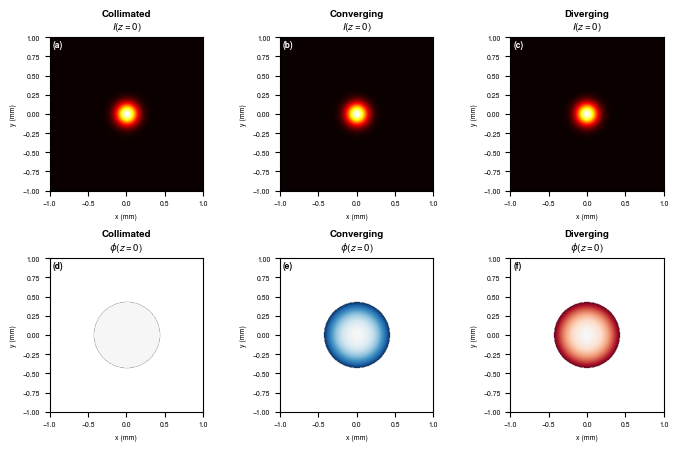

In [9]:
# Plot intensities and phases at z=0
fig, axes = plt.subplots(2, 3, figsize=(7, 4.5))

extent_mm = [-physical_size/2*1e3, physical_size/2*1e3, 
             -physical_size/2*1e3, physical_size/2*1e3]

titles = ['Collimated', 'Converging', 'Diverging']
intensities = [I_collimated, I_converging, I_diverging]
phases = [phase_collimated, phase_converging, phase_diverging]
fields = [E_collimated, E_converging, E_diverging]

# Top row: Intensities
for idx, (ax, I, title) in enumerate(zip(axes[0], intensities, titles)):
    im = ax.imshow(I, cmap='hot', extent=extent_mm)
    ax.set_title(f'{title}\n$I(z=0)$')
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.text(0.02, 0.98, f'({chr(97+idx)})', transform=ax.transAxes,
            fontweight='bold', va='top', color='white')

# Bottom row: Phases
for idx, (ax, phase, title) in enumerate(zip(axes[1], phases, titles)):
    # Mask phase outside beam
    phase_masked = jnp.where(amplitude > 0.01, phase, jnp.nan)
    vmax = jnp.nanmax(jnp.abs(phase_masked))
    if vmax < 0.1:
        vmax = 1.0  # For flat phase
    im = ax.imshow(phase_masked, cmap='RdBu_r', extent=extent_mm, vmin=-vmax, vmax=vmax)
    ax.set_title(f'{title}\n$\\phi(z=0)$')
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.text(0.02, 0.98, f'({chr(100+idx)})', transform=ax.transAxes,
            fontweight='bold', va='top', color='black')

plt.tight_layout()
plt.savefig('Figures/wavefronts_intensity_phase_z0.pdf', bbox_inches='tight')
plt.savefig('Figures/wavefronts_intensity_phase_z0.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Propagation: Where Phase Matters

Now we propagate all three beams and observe their dramatically different evolution.

In [10]:
# Propagation distances
z_positions = jnp.linspace(0, focal_length, 50)

# Storage for propagated intensities along central slice
def propagate_and_slice(E0, z_vals):
    """Propagate field and extract central x-slice at each z."""
    slices = []
    center_idx = grid_size // 2
    for z in z_vals:
        if z == 0:
            E_z = E0
        else:
            # Create OpticalWavefront and propagate
            wavefront = make_optical_wavefront(E0, wavelength, dx, z_position=0.0)
            propagated = angular_spectrum_prop(wavefront, float(z))
            E_z = propagated.field
        I_z = jnp.abs(E_z)**2
        slices.append(I_z[center_idx, :])  # Central horizontal slice
    return jnp.stack(slices)

# Propagate all three beams
print("Propagating collimated beam...")
xz_collimated = propagate_and_slice(E_collimated, z_positions)
print("Propagating converging beam...")
xz_converging = propagate_and_slice(E_converging, z_positions)
print("Propagating diverging beam...")
xz_diverging = propagate_and_slice(E_diverging, z_positions)
print("Done!")

Propagating collimated beam...
Propagating converging beam...
Propagating diverging beam...
Done!


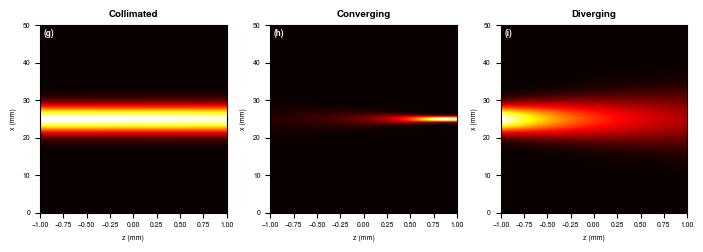

In [11]:
# Plot x-z propagation
fig, axes = plt.subplots(1, 3, figsize=(7, 2.5))

xz_data = [xz_collimated, xz_converging, xz_diverging]
titles = ['Collimated', 'Converging', 'Diverging']

extent_xz = [x[0]*1e3, x[-1]*1e3, 0, z_positions[-1]*1e3]

for idx, (ax, data, title) in enumerate(zip(axes, xz_data, titles)):
    # Normalize each for visualization
    data_norm = data / jnp.max(data)
    im = ax.imshow(data_norm.T, cmap='hot', extent=extent_xz, 
                   aspect='auto', origin='lower')
    ax.set_xlabel('z (mm)')
    ax.set_ylabel('x (mm)')
    ax.set_title(title)
    ax.text(0.02, 0.98, f'({chr(103+idx)})', transform=ax.transAxes,
            fontweight='bold', va='top', color='white')

plt.tight_layout()
plt.savefig('Figures/wavefronts_propagation_xz.pdf', bbox_inches='tight')
plt.savefig('Figures/wavefronts_propagation_xz.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Why Complex Fields?

The key insight: **intensity alone cannot predict propagation**. The phase contains all the information about whether a beam will focus, diverge, or propagate as a collimated beam.

This is why Janssen stores the full complex field $E(x,y) = A(x,y) e^{i\phi(x,y)}$.

/tmp/ipykernel_1967209/817667154.py:27: UserWarning: Glyph 8756 (\N{THEREFORE}) missing from font(s) TeX Gyre Heros.
  plt.tight_layout()
/tmp/ipykernel_1967209/817667154.py:28: UserWarning: Glyph 8756 (\N{THEREFORE}) missing from font(s) TeX Gyre Heros.
  plt.savefig('Figures/wavefronts_why_complex.pdf', dpi=300, bbox_inches='tight')
/tmp/ipykernel_1967209/817667154.py:28: UserWarning: Glyph 8756 (\N{THEREFORE}) missing from font(s) TeX Gyre Heros.
  plt.savefig('Figures/wavefronts_why_complex.pdf', dpi=300, bbox_inches='tight')
/tmp/ipykernel_1967209/817667154.py:29: UserWarning: Glyph 8756 (\N{THEREFORE}) missing from font(s) TeX Gyre Heros.
  plt.savefig('Figures/wavefronts_why_complex.png', dpi=300, bbox_inches='tight')
/home/qz7/janssen/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8756 (\N{THEREFORE}) missing from font(s) TeX Gyre Heros.
  fig.canvas.print_figure(bytes_io, **kw)


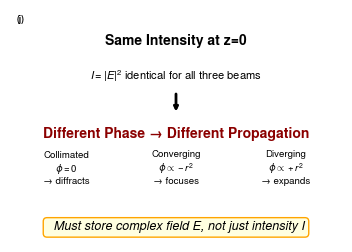

In [12]:
# Create a schematic showing the key message
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Draw schematic
ax.text(0.5, 0.85, 'Same Intensity at z=0', ha='center', fontsize=10, fontweight='bold')
ax.text(0.5, 0.70, '$I = |E|^2$ identical for all three beams', ha='center', fontsize=8)

ax.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.65),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

ax.text(0.5, 0.45, 'Different Phase → Different Propagation', 
        ha='center', fontsize=10, fontweight='bold', color='darkred')

ax.text(0.17, 0.25, 'Collimated\n$\\phi = 0$\n→ diffracts', ha='center', fontsize=7)
ax.text(0.50, 0.25, 'Converging\n$\\phi \\propto -r^2$\n→ focuses', ha='center', fontsize=7)
ax.text(0.83, 0.25, 'Diverging\n$\\phi \\propto +r^2$\n→ expands', ha='center', fontsize=7)

ax.text(0.5, 0.05, '∴ Must store complex field E, not just intensity I', 
        ha='center', fontsize=9, style='italic', 
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='orange'))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.text(0.02, 0.98, '(j)', transform=ax.transAxes, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('Figures/wavefronts_why_complex.pdf', bbox_inches='tight')
plt.savefig('Figures/wavefronts_why_complex.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Differentiability: Gradient of Focal Intensity

Because Janssen is built on JAX, we can compute gradients of any quantity with respect to beam parameters. Here we compute $\partial I(z=f) / \partial w_0$: how the focal plane intensity changes with the beam waist.

In [13]:
def focal_intensity(w0_param):
    """Compute intensity at focal plane for a converging Gaussian beam."""
    # Create beam with given waist
    amplitude = jnp.exp(-rr**2 / w0_param**2)
    phase = -k * rr**2 / (2 * focal_length)
    E0 = amplitude * jnp.exp(1j * phase)
    
    # Create wavefront and propagate to focus
    wavefront = make_optical_wavefront(E0, wavelength, dx, z_position=0.0)
    propagated = angular_spectrum_prop(wavefront, focal_length)
    I_f = jnp.abs(propagated.field)**2
    
    return I_f

def peak_focal_intensity(w0_param):
    """Scalar: peak intensity at focus."""
    I_f = focal_intensity(w0_param)
    return jnp.max(I_f)

# Compute gradient map: how does each pixel's focal intensity depend on w0?
# Use JAX's jacfwd to get the full Jacobian
grad_peak = jax.grad(peak_focal_intensity)

# Evaluate at nominal waist
w0_test = 200e-6
I_focal = focal_intensity(w0_test)
dI_dw0 = grad_peak(w0_test)

print(f"Peak focal intensity: {jnp.max(I_focal):.4f}")
print(f"Gradient dI_peak/dw0: {dI_dw0:.4e} (1/m)")
print(f"Interpretation: increasing w0 by 1 um changes peak intensity by {dI_dw0 * 1e-6:.4f}")

Peak focal intensity: 23.9040
Gradient dI_peak/dw0: 4.6823e+05 (1/m)
Interpretation: increasing w0 by 1 um changes peak intensity by 0.4682


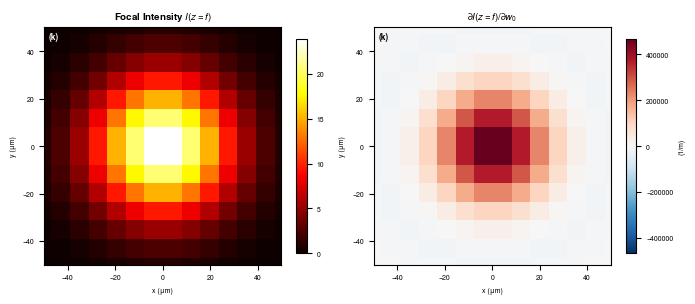

In [14]:
# Compute gradient map by finite difference (for visualization)
eps = 1e-6
I_f_plus = focal_intensity(w0_test + eps)
I_f_minus = focal_intensity(w0_test - eps)
dI_dw0_map = (I_f_plus - I_f_minus) / (2 * eps)

# Plot focal intensity and gradient
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Focal intensity
ax = axes[0]
extent_um = [-physical_size/2*1e6, physical_size/2*1e6,
             -physical_size/2*1e6, physical_size/2*1e6]
im = ax.imshow(I_focal, cmap='hot', extent=extent_um)
ax.set_xlabel('x (μm)')
ax.set_ylabel('y (μm)')
ax.set_title('Focal Intensity $I(z=f)$')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
plt.colorbar(im, ax=ax, shrink=0.8)
ax.text(0.02, 0.98, '(k)', transform=ax.transAxes, fontweight='bold', va='top', color='white')

# Gradient map
ax = axes[1]
vmax = jnp.max(jnp.abs(dI_dw0_map))
im = ax.imshow(dI_dw0_map, cmap='RdBu_r', extent=extent_um, vmin=-vmax, vmax=vmax)
ax.set_xlabel('x (μm)')
ax.set_ylabel('y (μm)')
ax.set_title('$\\partial I(z=f) / \\partial w_0$')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
plt.colorbar(im, ax=ax, shrink=0.8, label='(1/m)')
ax.text(0.02, 0.98, '(k)', transform=ax.transAxes, fontweight='bold', va='top', color='black')

plt.tight_layout()
plt.savefig('Figures/wavefronts_gradient.pdf', bbox_inches='tight')
plt.savefig('Figures/wavefronts_gradient.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Optimization: Recovering Beam Waist from Target Focal Spot

Given a target focal spot, can we recover the beam waist that produces it? This is an inverse problem that gradient descent can solve.

In [15]:
# Target: focal spot from w0 = 200 um
w0_target = 200e-6
I_target = focal_intensity(w0_target)

# Start with wrong guess
w0_init = 350e-6  # Start with 350 um (wrong!)

def loss_fn(w0_param):
    """MSE between predicted and target focal intensity."""
    I_pred = focal_intensity(w0_param)
    return jnp.mean((I_pred - I_target)**2)

grad_loss = jax.grad(loss_fn)

# Optimization with Adam
optimizer = optax.adam(learning_rate=5e-6)
w0_current = w0_init
opt_state = optimizer.init(w0_current)

n_iterations = 50
w0_history = [w0_current]
loss_history = [float(loss_fn(w0_current))]

print(f"Target w0: {w0_target*1e6:.0f} um")
print(f"Initial w0: {w0_init*1e6:.0f} um")
print(f"Initial loss: {loss_history[0]:.6f}")
print("\nOptimizing...")

for i in range(n_iterations):
    grads = grad_loss(w0_current)
    updates, opt_state = optimizer.update(grads, opt_state)
    w0_current = optax.apply_updates(w0_current, updates)
    
    w0_history.append(float(w0_current))
    loss_history.append(float(loss_fn(w0_current)))
    
    if (i + 1) % 10 == 0:
        print(f"  Iter {i+1}: w0 = {w0_current*1e6:.1f} um, loss = {loss_history[-1]:.6f}")

print(f"\nFinal w0: {w0_current*1e6:.1f} um (target: {w0_target*1e6:.0f} um)")
print(f"Error: {abs(w0_current - w0_target)*1e6:.2f} um")

Target w0: 200 um
Initial w0: 350 um
Initial loss: 3.899279

Optimizing...
  Iter 10: w0 = 301.8 um, loss = 1.241943
  Iter 20: w0 = 262.8 um, loss = 0.341526
  Iter 30: w0 = 236.4 um, loss = 0.090567
  Iter 40: w0 = 220.5 um, loss = 0.024642
  Iter 50: w0 = 211.4 um, loss = 0.007023

Final w0: 211.4 um (target: 200 um)
Error: 11.41 um


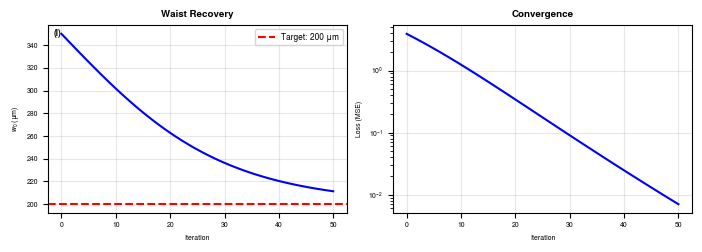

In [16]:
# Plot optimization convergence
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))

# w0 vs iteration
ax = axes[0]
ax.plot(range(len(w0_history)), [w*1e6 for w in w0_history], 'b-', linewidth=1.5)
ax.axhline(y=w0_target*1e6, color='r', linestyle='--', label=f'Target: {w0_target*1e6:.0f} μm')
ax.set_xlabel('Iteration')
ax.set_ylabel('$w_0$ (μm)')
ax.set_title('Waist Recovery')
ax.legend()
ax.grid(True, alpha=0.3)
ax.text(0.02, 0.98, '(l)', transform=ax.transAxes, fontweight='bold', va='top')

# Loss vs iteration
ax = axes[1]
ax.semilogy(range(len(loss_history)), loss_history, 'b-', linewidth=1.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Convergence')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figures/wavefronts_optimization.pdf', bbox_inches='tight')
plt.savefig('Figures/wavefronts_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

## Publication Figure

Combined figure for the Janssen paper showing:
- (a-c) Three Gaussian beams at z=0: identical intensity
- (d-f) Their phase profiles: flat, converging, diverging  
- (g-i) Propagation in z: completely different evolution
- (j) Why we store complex fields
- (k) Gradient: sensitivity of focal intensity to waist
- (l) Optimization: recovering waist from target focal spot

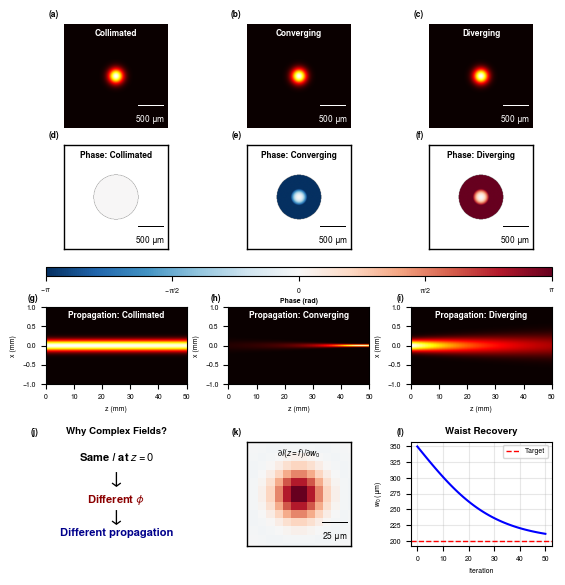

In [37]:
# Create publication figure
import string
from matplotlib_scalebar.scalebar import ScaleBar

fig = plt.figure(figsize=(7, 8.0))
# Grid: 46 rows x 30 cols for finer control with tighter spacing
gs = mpgs.GridSpec(46, 30, figure=fig, hspace=0.4, wspace=0.4)

subfig_idx = 0
def get_label():
    global subfig_idx
    label = f'({string.ascii_lowercase[subfig_idx]})'
    subfig_idx += 1
    return label

extent_mm = [-physical_size/2*1e3, physical_size/2*1e3,
             -physical_size/2*1e3, physical_size/2*1e3]

# Column positions: 8 cols per figure, 2 col gap between them
# 0:1 empty, 1:9 fig1, 9:11 gap, 11:19 fig2, 19:21 gap, 21:29 fig3, 29:30 empty
col_starts = [1, 11, 21]
col_width = 8

# Row layout (46 rows total):
# Row 1 (a-c): rows 1:9 - Intensities (8 rows)
# Gap: rows 9:10 (1 row)
# Row 2 (d-f): rows 10:18 - Phases (8 rows)
# Gap: rows 18:19 (1 row)
# Colorbar: rows 19:20 (1 row)
# Gap: rows 20:22 (2 rows)
# Row 3 (g-i): rows 22:28 - Propagation (6 rows)
# Gap: rows 28:32 (4 rows) - increased from 2 to 4
# Row 4 (j-l): rows 32:40 - Why complex, Gradient, Optimization (8 rows)

# Row 1: Intensities at z=0 (a-c)
titles = ['Collimated', 'Converging', 'Diverging']
intensities = [I_collimated, I_converging, I_diverging]

for idx in range(3):
    ax = fig.add_subplot(gs[1:9, col_starts[idx]:col_starts[idx]+col_width])
    im = ax.imshow(intensities[idx], cmap='hot', extent=extent_mm)
    # Title inside figure, top center, white
    ax.text(0.5, 0.95, titles[idx], transform=ax.transAxes,
            fontweight='bold', va='top', ha='center', color='white')
    ax.axis('off')
    # Add scalebar (dx is in mm since extent is in mm)
    scalebar = ScaleBar(1e-3, 'm', length_fraction=0.3, location='lower right',
                        color='white', box_alpha=0, font_properties={'size': 6})
    ax.add_artist(scalebar)
    # Label outside top-left corner
    ax.text(-0.05, 1.05, get_label(), transform=ax.transAxes,
            fontweight='bold', va='bottom', ha='right')

# Row 2: Phases at z=0 (d-f)
phases = [phase_collimated, phase_converging, phase_diverging]
vmax_phase = jnp.pi  # Use pi for phase range

for idx in range(3):
    ax = fig.add_subplot(gs[10:18, col_starts[idx]:col_starts[idx]+col_width])
    phase_masked = jnp.where(amplitude > 0.01, phases[idx], jnp.nan)
    im_phase = ax.imshow(phase_masked, cmap='RdBu_r', extent=extent_mm,
                   vmin=-vmax_phase, vmax=vmax_phase)
    # Title inside figure, top center, black
    ax.text(0.5, 0.95, f'Phase: {titles[idx]}', transform=ax.transAxes,
            fontweight='bold', va='top', ha='center', color='black')
    # Turn off ticks but keep spines for the box
    ax.set_xticks([])
    ax.set_yticks([])
    # Add box around the figure
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    # Add scalebar (dx is in mm since extent is in mm)
    scalebar = ScaleBar(1e-3, 'm', length_fraction=0.3, location='lower right',
                        color='black', box_alpha=0, font_properties={'size': 6})
    ax.add_artist(scalebar)
    # Label outside top-left corner
    ax.text(-0.05, 1.05, get_label(), transform=ax.transAxes,
            fontweight='bold', va='bottom', ha='right')

# Horizontal colorbar for phase - 1 row thick
cbar_ax = fig.add_subplot(gs[19:20, 1:29])
cbar = fig.colorbar(im_phase, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Phase (rad)', fontweight='bold', labelpad=2)
cbar.set_ticks([-jnp.pi, -jnp.pi/2, 0, jnp.pi/2, jnp.pi])
cbar.set_ticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

# Row 3: Propagation x-z (g-i)
xz_data = [xz_collimated, xz_converging, xz_diverging]
extent_xz = [0, z_positions[-1]*1e3, x[0]*1e3, x[-1]*1e3]

for idx in range(3):
    ax = fig.add_subplot(gs[22:28, col_starts[idx]:col_starts[idx]+col_width])
    data_norm = xz_data[idx] / jnp.max(xz_data[idx])
    im = ax.imshow(data_norm.T, cmap='hot', extent=extent_xz,
                   aspect='auto', origin='lower')
    ax.set_xlabel('z (mm)')
    ax.set_ylabel('x (mm)')
    # Title inside figure, top center, white
    ax.text(0.5, 0.95, f'Propagation: {titles[idx]}', transform=ax.transAxes,
            fontweight='bold', va='top', ha='center', color='white')
    # Label outside top-left corner
    ax.text(-0.05, 1.05, get_label(), transform=ax.transAxes,
            fontweight='bold', va='bottom', ha='right')

# Row 4: (j) Why complex, (k) Gradient, (l) Optimization

# (j) Why complex - text schematic
ax = fig.add_subplot(gs[32:40, col_starts[0]:col_starts[0]+col_width])
ax.text(0.5, 0.80, 'Same $I$ at $z=0$', ha='center', fontsize=8, fontweight='bold')
ax.text(0.5, 0.55, '↓', ha='center', fontsize=14)
ax.text(0.5, 0.35, 'Different $\\phi$', ha='center', fontsize=8, fontweight='bold', color='darkred')
ax.text(0.5, 0.15, '↓', ha='center', fontsize=14)
ax.text(0.5, 0.0, 'Different propagation', ha='center', fontsize=8, fontweight='bold', color='darkblue')
ax.set_xlim(0, 1)
ax.set_ylim(-0.1, 1)
ax.axis('off')
ax.set_title('Why Complex Fields?')
# Label outside top-left corner
ax.text(-0.05, 1.05, get_label(), transform=ax.transAxes,
        fontweight='bold', va='bottom', ha='right')

# (k) Gradient map - with scalebar and box outline like phase images
ax = fig.add_subplot(gs[32:40, col_starts[1]:col_starts[1]+col_width])
extent_um = [-physical_size/2*1e6, physical_size/2*1e6,
             -physical_size/2*1e6, physical_size/2*1e6]
vmax = jnp.max(jnp.abs(dI_dw0_map))
im = ax.imshow(dI_dw0_map, cmap='RdBu_r', extent=extent_um, vmin=-vmax, vmax=vmax)
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
# Title inside figure, top center, black
ax.text(0.5, 0.95, '$\\partial I(z{=}f) / \\partial w_0$', transform=ax.transAxes,
        fontweight='bold', va='top', ha='center', color='black')
# Turn off ticks but keep spines for the box
ax.set_xticks([])
ax.set_yticks([])
# Add box around the figure
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
# Add scalebar (extent is in um, so 1e-6 m per unit)
scalebar = ScaleBar(1e-6, 'm', length_fraction=0.3, location='lower right',
                    color='black', box_alpha=0, font_properties={'size': 6})
ax.add_artist(scalebar)
# Label outside top-left corner
ax.text(-0.05, 1.05, get_label(), transform=ax.transAxes,
        fontweight='bold', va='bottom', ha='right')

# (l) Optimization convergence
ax = fig.add_subplot(gs[32:40, col_starts[2]:col_starts[2]+col_width])
ax.plot(range(len(w0_history)), [w*1e6 for w in w0_history], 'b-', linewidth=1.5)
ax.axhline(y=w0_target*1e6, color='r', linestyle='--', linewidth=1, label=f'Target')
ax.set_xlabel('Iteration')
ax.set_ylabel('$w_0$ (μm)')
ax.set_title('Waist Recovery')
ax.legend(loc='upper right', fontsize=5)
ax.grid(True, alpha=0.3)
# Label outside top-left corner
ax.text(-0.05, 1.05, get_label(), transform=ax.transAxes,
        fontweight='bold', va='bottom', ha='right')

plt.savefig('Figures/wavefronts_publication_figure.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.savefig('Figures/wavefronts_publication_figure.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

<cell_type>markdown</cell_type>## Summary

This tutorial demonstrated:

1. **Complex field representation**: Storing both amplitude and phase is essential for wave optics
2. **Phase determines propagation**: Beams with identical intensity but different phase evolve completely differently
3. **Differentiability**: JAX enables computing gradients of any downstream quantity w.r.t. beam parameters
4. **Inverse problems**: Gradient descent can recover beam parameters from target specifications

### Key Functions

| Function | Description |
|----------|-------------|
| `gaussian_beam()` | Generate Gaussian beam field |
| `angular_spectrum_prop()` | Propagate field using angular spectrum method |
| `jax.grad()` | Compute gradients for optimization |